<a href="https://colab.research.google.com/github/SonikaRavi99/Calculator/blob/master/Image%20Clasification%20using%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import machine learning and data visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import tensorflow_datasets as tfds
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set random seeds for reproducibility to ensures we get the same results when running the code multiple times
tf.random.set_seed(42)
np.random.seed(42)

# Print TensorFlow version for debugging and documentation purposes
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.18.0


In [ ]:
# Load the Oxford-IIIT Pet Dataset, which contains images of 37 pet breeds
print("Loading dataset...")
dataset_name = "oxford_iiit_pet"

# Load dataset with an 80-20 train-validation split
# as_supervised=True formats the data as (image, label) pairs
# with_info=True returns dataset info including feature descriptions
(train_ds, val_ds), ds_info = tfds.load(
    dataset_name,
    split=['train[:80%]', 'train[80%:]'],  # Use 80% for training, 20% for validation
    as_supervised=True,
    with_info=True
)

# Extract class information from the dataset
# Number of pet breeds
num_classes = ds_info.features['label'].num_classes
# Names of the pet breeds
class_names = ds_info.features['label'].names
print(f"Number of classes: {num_classes}")
# Show first 5 class names
print(f"Class names: {class_names[:5]}...")

Loading dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.MS8WTM_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.MS8WTM_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
Number of classes: 37
Class names: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle']...


In [ ]:
# Define key parameters for image processing
IMG_SIZE = (224, 224)
# Number of images to process in one batch
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Create preprocessing function for training data with data augmentation
# Data augmentation helps the model generalize better by creating variations of the training images
def preprocess_train(image, label):
    # Resize the image to the required dimensions
    image = tf.image.resize(image, IMG_SIZE)

    # Data augmentation: apply random transformations to create variety in the training data
    image = tf.image.random_flip_left_right(image)  # Randomly flip horizontally
    image = tf.image.random_brightness(image, 0.1)  # Randomly adjust brightness

    # Normalize pixel values to range [0,1] - helps AI learn better
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Preprocessing for validation data (no augmentation needed for validation)
def preprocess_val(image, label):
    # Resize the image to the required dimensions
    image = tf.image.resize(image, IMG_SIZE)

    # Normalize pixel values to range [0,1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
# Apply the preprocessing functions to the training dataset
train_ds = train_ds.map(preprocess_train, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(AUTOTUNE)
# Apply preprocessing to validation dataset (no shuffling needed)
val_ds = val_ds.map(preprocess_val, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(AUTOTUNE)

In [ ]:
# Inspect the processed data to ensure it looks correct
print("Checking data:")
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")  # Should be (BATCH_SIZE, 224, 224, 3)
    print(f"Label batch shape: {labels.shape}")  # Should be (BATCH_SIZE,)

    # Check if image values are properly normalized to [0,1]
    print(f"Image min-max range: {tf.reduce_min(images).numpy():.4f}-{tf.reduce_max(images).numpy():.4f}")

    # Check the range of label values
    print(f"Labels range: {tf.reduce_min(labels).numpy()}-{tf.reduce_max(labels).numpy()}")

    # Count occurrences of each class in this batch to check class distribution
    print(f"Label distribution: {np.bincount(labels.numpy())}")

Checking data:
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Image min-max range: -0.0004-1.0003
Labels range: 0-35
Label distribution: [1 3 2 0 0 3 0 2 0 0 2 1 1 0 2 1 0 1 0 0 0 3 2 0 1 0 0 2 0 1 1 0 0 0 0 3]


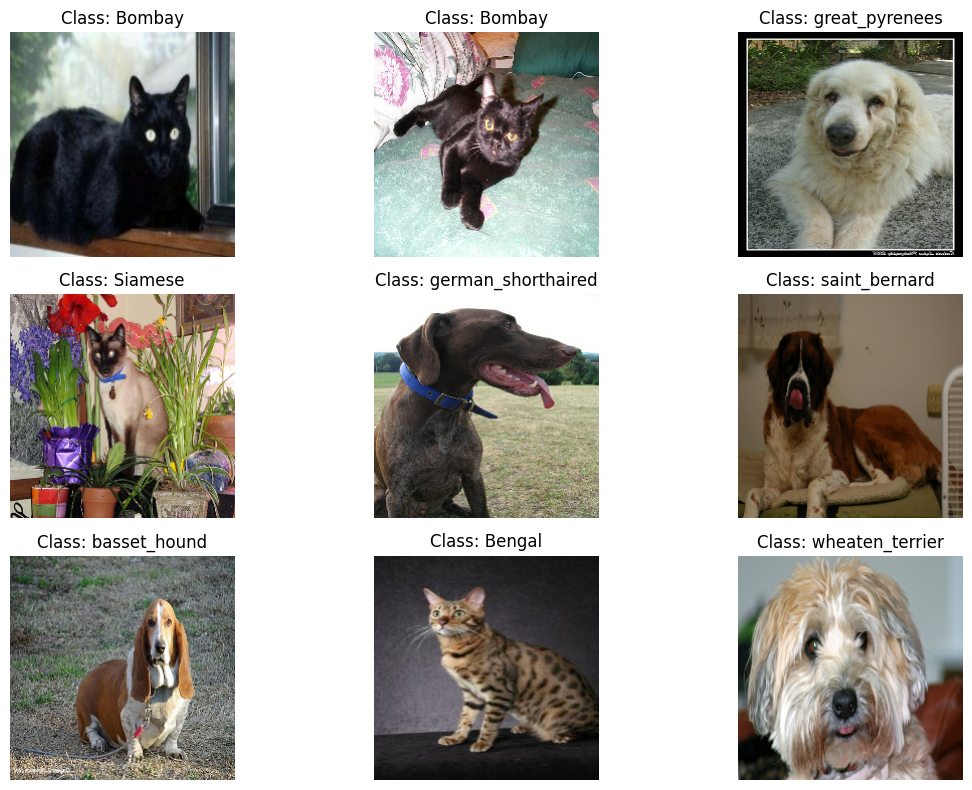

In [ ]:
# Visualize sample images to ensure they look correct
plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
  # Display up to 9 images in a 3x3 grid
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Class: {class_names[labels[i]]}")
        plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Build the model architecture using transfer learning with ResNet50V2
print("Building model with ResNet50V2...")

# Load the pre-trained ResNet50V2 model (excluding the top classification layers)
# Using pre-trained weights from ImageNet significantly reduces training time and improves accuracy
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model initially to prevent weights from being updated during training
# This is important in transfer learning to preserve the learned features
base_model.trainable = False

# Build a functional model with custom classification layers on top of the base model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Print model summary to visualize the architecture and parameter count
print("Model summary:")
model.summary()


Building model with ResNet50V2...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 37)                  │           9,509 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,107,045 (91.96 MB)

 Trainable params: 538,149 (2.05 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

In [ ]:
# Phase 1: Train only the top layers while keeping the base model frozen
# This allows the new layers to adapt to our specific task before fine-tuning the whole model
print("Phase 1: Training top layers only...")

# Compile the model with appropriate optimizer, loss function, and metrics
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Create callbacks for more efficient training
# Early stopping to prevent overfitting by monitoring validation accuracy
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when training plateaus
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Train the model in the first phase
# This will only update the weights of the layers we added on top of the base model
history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)



Phase 1: Training top layers only...
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 177ms/step - accuracy: 0.4278 - loss: 2.2938 - val_accuracy: 0.8560 - val_loss: 0.4816 - learning_rate: 0.0010
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.8614 - loss: 0.4642 - val_accuracy: 0.8696 - val_loss: 0.4169 - learning_rate: 0.0010
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.8984 - loss: 0.2883 - val_accuracy: 0.8859 - val_loss: 0.3916 - learning_rate: 0.0010
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.9192 - loss: 0.2183 - val_accuracy: 0.8872 - val_loss: 0.3918 - learning_rate: 0.0010
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9434 - loss: 0.1598 - val_accuracy: 0.8981 - val_loss: 0.3781 - learning_rate: 0.0010
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.9597 - loss: 0.1358 - val_accuracy: 0.8995 - val_loss: 0.3679 - learning_rate: 0.0010
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 124

In [ ]:
# Phase 2: Fine-tune the model by unfreezing and training some of the base model layers
# This allows the model to adapt pre-trained features to our specific dataset
print("\nPhase 2: Fine-tuning model...")

# Unfreeze the base model to allow weights to be updated
base_model.trainable = True

# Keep the first 100 layers frozen and only fine-tune the deeper layers
# Earlier layers capture more generic features (edges, textures) that transfer well between tasks
# Later layers capture more task-specific features that benefit from fine-tuning
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile model with lower learning rate for fine-tuning
# Lower learning rate is critical when fine-tuning to prevent destroying pre-trained weights
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Much lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train with fine-tuning, continuing from where the first phase left off
history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # Train for more epochs in the fine-tuning phase
    initial_epoch=history_phase1.epoch[-1] + 1,  # Continue from where phase 1 ended
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)



Phase 2: Fine-tuning model...
Epoch 11/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 56s 231ms/step - accuracy: 0.8028 - loss: 0.6244 - val_accuracy: 0.8845 - val_loss: 0.4142 - learning_rate: 1.0000e-05
Epoch 12/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.9074 - loss: 0.3014 - val_accuracy: 0.8777 - val_loss: 0.4505 - learning_rate: 1.0000e-05
Epoch 13/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.9321 - loss: 0.2008 - val_accuracy: 0.8723 - val_loss: 0.4692 - learning_rate: 1.0000e-05
Epoch 14/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9564 - loss: 0.1344
Epoch 14: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - accuracy: 0.9564 - loss: 0.1345 - val_accuracy: 0.8777 - val_loss: 0.4738 - learning_rate: 1.0000e-05
Epoch 15/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.9534 - loss: 0.1356 - val_accuracy: 0.8723 - val_loss: 0.4821 - learning_rate: 2.0000e-06
Epoch 16/20
92/92 ━━━━━━━━

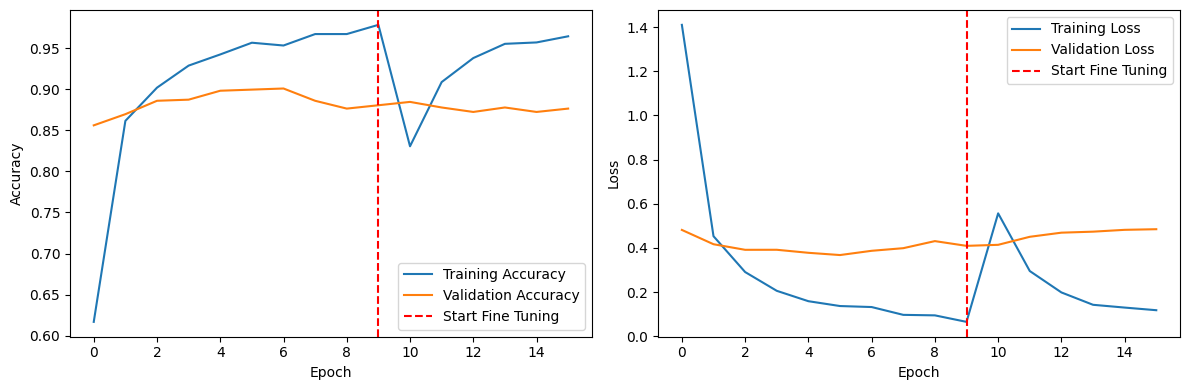

In [ ]:
# Visualize training progress over both phases to evaluate model performance
# This helps identify overfitting, underfitting, or other training issues

# Combine training histories from both phases for complete visualization
def combine_histories(h1, h2):
    combined = {}
    for key in h1.history.keys():
        combined[key] = h1.history[key] + h2.history[key]
    return combined

history_combined = combine_histories(history_phase1, history_phase2)

# Plot training and validation accuracy and loss over time
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_combined['accuracy'], label='Training Accuracy')
plt.plot(history_combined['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=len(history_phase1.history['accuracy'])-1, color='r', linestyle='--',
            label='Start Fine Tuning')  # Mark where fine-tuning began
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_combined['loss'], label='Training Loss')
plt.plot(history_combined['val_loss'], label='Validation Loss')
plt.axvline(x=len(history_phase1.history['loss'])-1, color='r', linestyle='--',
            label='Start Fine Tuning')  # Mark where fine-tuning began
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the final model on the validation dataset
# This provides a final assessment of model performance
print("Evaluating model...")
test_loss, test_acc = model.evaluate(val_ds, verbose=1)
print(f"\n✅ Final Model Accuracy: {test_acc:.2%}")


Evaluating model...
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9031 - loss: 0.3555

✅ Final Model Accuracy: 88.45%


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


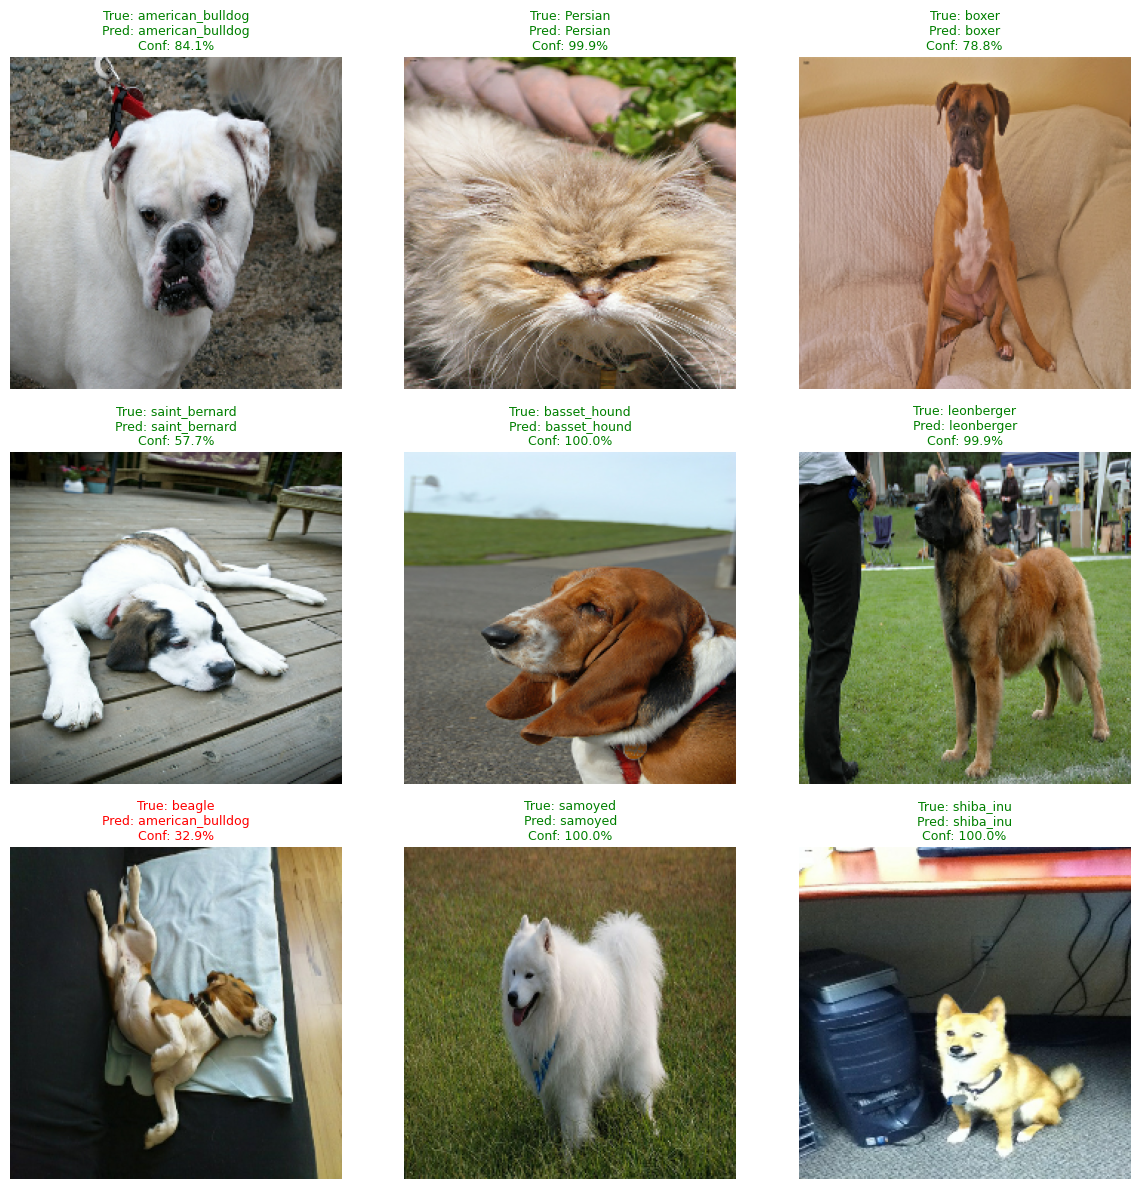

In [ ]:
# Visualize model predictions on validation images
# This helps identify where the model performs well or makes mistakes

# Get a batch of validation images and make predictions
images_batch, labels_batch = next(iter(val_ds))
predictions = model.predict(images_batch)
predicted_classes = np.argmax(predictions, axis=1)

# Display predictions with confidence scores
plt.figure(figsize=(12, 12))
for i in range(min(9, len(images_batch))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_batch[i])

    # Get true and predicted labels
    true_label = class_names[labels_batch[i]]
    pred_label = class_names[predicted_classes[i]]
    confidence = predictions[i][predicted_classes[i]] * 100

    # Color-code the title based on whether prediction was correct (green) or wrong (red)
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%",
              color=color, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Analyze model performance for each class
# This helps identify which classes are challenging for the model
print("\nCalculating per-class accuracy...")

# Initialize lists to store all validation labels and predictions
all_labels = []
all_preds = []

# Collect predictions for all validation data
for images, labels in val_ds:
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    all_labels.extend(labels.numpy())
    all_preds.extend(pred_classes)

# Convert to numpy arrays for easier processing
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Calculate accuracy per class to identify problematic classes
class_accuracies = {}
for i in range(num_classes):
    class_mask = (all_labels == i)
    if np.sum(class_mask) > 0:
        class_acc = np.mean(all_preds[class_mask] == i)
        class_accuracies[class_names[i]] = class_acc

# Create and sort dataframe of class accuracies for better visualization
class_acc_df = pd.DataFrame(list(class_accuracies.items()), columns=['Class', 'Accuracy'])
class_acc_df = class_acc_df.sort_values('Accuracy', ascending=False)
print(class_acc_df)  # Display class-wise accuracy



Calculating per-class accuracy...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
                         Class  Accuracy
31                   shiba_in

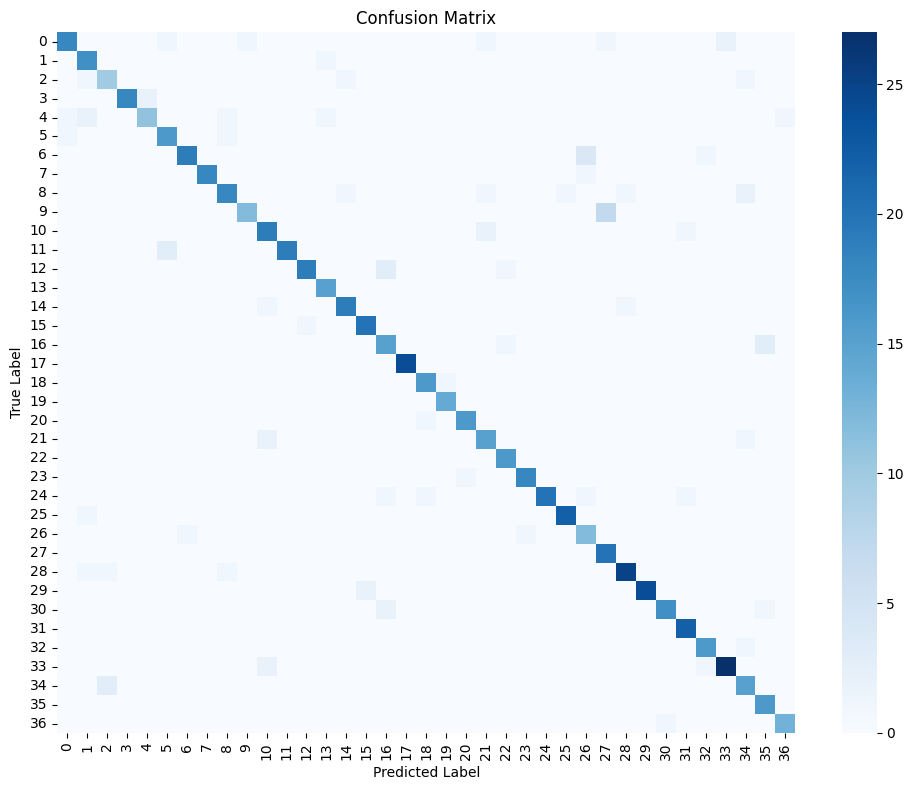

In [ ]:
# Create a confusion matrix to visualize prediction patterns
# This helps identify common misclassifications between specific classes
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix (using a heatmap for better visualization)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [ ]:
# Save the trained model to disk for future use
# This allows deployment without retraining
model.save('pet_classifier_resnet.h5')
print("Model saved as 'pet_classifier_resnet.h5'")

Model saved as 'pet_classifier_resnet.h5'


In [ ]:
# Define a function to make predictions on new images
# This allows testing the model on images not in the dataset
def predict_single_image(img_path):
    """
    Predict the breed of a pet in a single image.

    Args:
        img_path: Path to the image file

    Returns:
        Tuple of (predicted_class_name, confidence_percentage)
    """
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = prediction[0][predicted_class] * 100

    # Display result with the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]}\nConfidence: {confidence:.1f}%")
    plt.axis('off')
    plt.show()

    # Print top 3 predictions for additional context
    top_3_idx = np.argsort(prediction[0])[-3:][::-1]
    print("Top 3 predictions:")
    for idx in top_3_idx:
        print(f"{class_names[idx]}: {prediction[0][idx]*100:.1f}%")

    return class_names[predicted_class], confidence

print("\nModel ready for predictions!")
print("You can use predict_single_image('your_image.jpg') to test the model")


Model ready for predictions!
You can use predict_single_image('your_image.jpg') to test the model


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


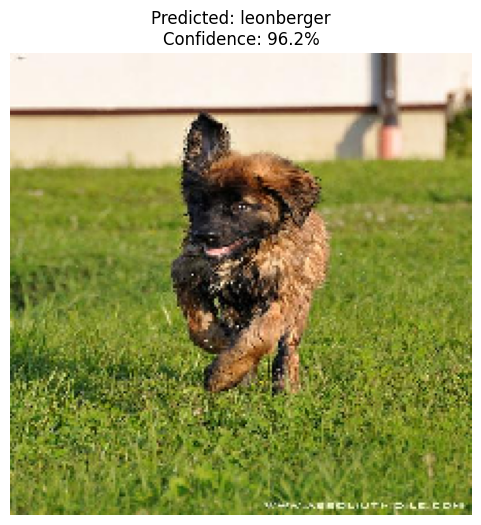

Top 3 predictions:
leonberger: 96.2%
wheaten_terrier: 2.4%
keeshond: 0.7%


('leonberger', np.float32(96.20805))

In [ ]:
predict_single_image('pet_image_0.jpg')